## Importing the necessary libraries

In [1]:
import cv2
import numpy as np
import glob
import os
from skimage.util import random_noise
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

## Obtaining the training data and the IDs of each image


ids_train = [] #storing the image ids of the training set
with open("C:\\Users\\Rohit\\Desktop\\LAB WORK(IMP)\\EE610\\Assignment\\EE610-Image-Processing\\Assignment2\\BSDS300\\iids_test.txt", "r") as a_file:
  for line in a_file:
    stripped_line = int(line.strip())#stripping any blank space
    ids_train.append(stripped_line)#appending the final id to the array


In [2]:
#path = "C:\\Users\\Rohit\\Desktop\\LAB WORK(IMP)\\EE610\\Assignment\\EE610-Image-Processing\\Assignment2\\BSDS300\\images\\train\\"

directory = "C:\\Users\\Rohit\\Desktop\\LAB WORK(IMP)\\EE610\\Assignment\\EE610-Image-Processing\\Assignment2\\BDS500\\train\\"
img_train = []
ids_img_train = []
for filename in os.listdir(directory):
    ids_img_train.append(int(filename[:-4]))
    img_train.append(cv2.imread(directory + filename))

## Obtaining the validation data

In [3]:
directory = "C:\\Users\\Rohit\\Desktop\\LAB WORK(IMP)\\EE610\\Assignment\\EE610-Image-Processing\\Assignment2\\BDS500\\val\\"
img_val = []
ids_img_val = []
for filename in os.listdir(directory):
    ids_img_val.append(int(filename[:-4]))
    img_val.append(cv2.imread(directory + filename, cv2.IMREAD_COLOR))

## Obtaining the testing data and the IDs of each image

In [4]:
directory = "C:\\Users\\Rohit\\Desktop\\LAB WORK(IMP)\\EE610\\Assignment\\EE610-Image-Processing\\Assignment2\\BDS500\\test\\"
img_test = []
ids_img_test = []
for filename in os.listdir(directory):
    ids_img_test.append(int(filename[:-4]))
    img_test.append(cv2.imread(directory + filename, cv2.IMREAD_COLOR))

## Choose the value for W

In [5]:
W = 27

## Defining the function for blurring of an image and other relevant functon definitions

In [6]:
def blur(img_array, kernel_size):
    """Appropriate blurring of images with the given kernel 

    Args:
        img_array ([numpy array]): the array of RGB images
        kernel_size ([tuple]): (W,W), where W is an odd integer

    Returns:
        [numpy array]: the array of blurred images (RGB)
    """
    img_blur = []
    for i in range(0, len(img_array)):
        img_blur.append(cv2.blur(img_array[i], kernel_size))
    return img_blur


In [7]:
# https://stackoverflow.com/questions/59735866/how-to-create-noisy-images-for-data-augmentation?noredirect=1&lq=1
def noise(img_array, mode="s&p", amount=0.011):
    """Adds noise to the images of an image array and returns an image array back.

    Args:
        img_array ([numpy array]): the array of images (RGB)
        mode (str, optional): Defines the noise model to be added. Defaults to "s&p".
        amount (float, optional): Defines the amount of salt and pepper noise to be added. Defaults to 0.011.

    Returns:
        numpy array: contains the images with noise added.
    """
    img_noise = []
    for i in range(0, len(img_array)):
        noise = random_noise(img_array[i], mode=mode, amount=amount)#  returns a floating-point array in the range [0, 1]
        noise = np.array(255 * noise, dtype=np.uint8)# we change it to range [0,255] by multiplying by 255 and then change the datatype to 'uint8'
        img_noise.append(noise)
    return img_noise

## Blurring and adding noise to the images

### Blurring the images

We have to now blur the images several times with different kernel sizes and add noise to the images.

We first select the kernel size randomly. Since we need an odd kernel size we generate an integer and then apply $f(x) = 2x + 1$.

In [8]:
blur_freq = 5# defines the number of times we want to degrade our image via blurring
blur_kernel = np.uint8(2.*np.random.randint(1, 5, blur_freq) + 1) # generating an odd sized kernel randomly
blur_kernel
# the above kernel is kept fixed for the rest of the code!!

array([9, 7, 3, 3, 5], dtype=uint8)

We then go to blurring our images with the above given kernel sizes.

In [9]:
img_train_blur, img_val_blur, img_test_blur = img_train, img_val, img_test 
for i in blur_kernel:
    kernel = (i, i)
    img_train_blur = blur(img_train_blur, kernel)
    img_val_blur =blur(img_val_blur, kernel)
    img_test_blur = blur(img_test_blur, kernel)

### Adding noise to the images

We now are going to add salt and pepper noise to our images of different amounts. We again do this randomly, however fix it for the rest of the code!!

We begin by creating an array of the amounts of salt pepper noise we are going to add in our images.

In [10]:
sp_freq = 5
sp_amt = 0.1*np.random.rand(sp_freq)
sp_amt

array([0.02761502, 0.05911294, 0.08687039, 0.01261078, 0.04980652])

We proceed to add noise to our images

In [11]:
img_train_noise, img_val_noise, img_test_noise = img_train_blur, img_val_blur, img_test_blur 
for i in sp_amt:
    img_train_noise = noise(img_train_noise, amount=i)
    img_val_noise = noise(img_val_noise, amount = i)
    img_test_noise = noise(img_test_noise, amount=i)

## Displaying a few images to demonstrate the degradation

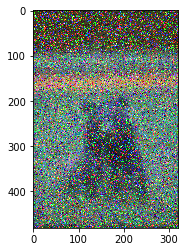

In [12]:
plt.imshow(img_train_noise[1])
plt.show()

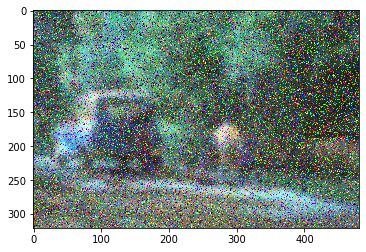

In [13]:
#cv2.imshow("First image", img_train_noise[1])
#cv2.imshow("Second image", img_test_noise[6])
#cv2.waitKey(-1)

plt.imshow(img_test_noise[6])
plt.show()

## Mining the images for w $\times$ w patches

In [14]:
#taken from sirs code(shared by sir on teams!)
def extract(img, W, w, numPatches):
    """Extracts the wxw patches from an image and the central pixel of each patch

    Args:
        img (numpy array): an array of np.uint8 values (RGB)
        W (integer): Patch max window size
        w (integer): sub-patch size
        numPatches (integer): Number of patches to be extracted from this image
        central_pixel (array): array of central pixels of each of the patch mined
    Returns:
        array: returns a numPatchxWxWx3 array and the array of central pixels
    """

    patches = np.empty((numPatches,W,W,3), dtype=float) # Initilizing patch n-d array
    central_pixel = np.empty((numPatches, 3), dtype = float)
    for i in range(numPatches): # For number of patches
        x = np.random.randint(0, img.shape[0]-W+1) # Random x location so that the patch 
                                                # remains within image boundaries
        y = np.random.randint(0, img.shape[1]-W+1) # Random y location
                                                # remains within image boundaries
        patches[i,:,:,:] = img[x:x+W,y:y+W,:]/255.0 # Extract patch
        central_pixel[i] = img[x+W//2, y+W//2, :]/255.0#extract central pixel
    return patches, central_pixel                                       # Divide by 255 for float images

### Displaying a patch of an image

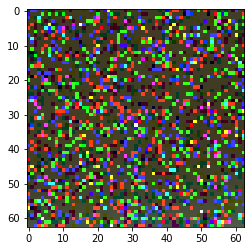

In [15]:
p, c = extract(img_train_noise[1], 63, 43, 5)
plt.imshow(p[1])
plt.show()

## Creating the final dataset of patches

In [16]:
def prepare(img_array, W, w, numPatches):
    X_in = np.empty((numPatches*len(img_array), 3*W*W), dtype=float)
    X_out = np.empty((numPatches*len(img_array), 3), dtype = float)
    for i in range(0, len(img_array)):
        patch, central = extract(img_array[i], W, w, numPatches)
        for j in range(0, numPatches):
            X_in[numPatches*i + j] =  patch[j].flatten()
            X_out[numPatches*i + j] = central[j]
    return X_in, X_out

In [17]:
W = 63
w = 43
numPatches = 15
train_in, train_out = prepare(img_train_noise, W, w, numPatches)
val_in, val_out = prepare(img_val_noise, W, w, numPatches)
test_in, test_out = prepare(img_test_noise, W, w, numPatches)

In [18]:
pred = np.empty_like(val_out)
pred_train = np.empty_like(train_out)
regressor_arr = []
for i in range(0, 3):
    regressor = SVR(kernel='rbf', gamma = "scale")
    regressor.fit(train_in[:,i*W*W:(i+1)*W*W],train_out[:, i])
    regressor_arr.append(regressor)
    pred_train[:, i] = regressor.predict(train_in[:, i*W*W:(i+1)*W*W])
    pred[:, i] = regressor.predict(val_in[:, i*W*W:(i+1)*W*W])

In [19]:
(mean_squared_error(pred_train, train_out)/3)**(0.5)

0.049235330324529376

In [20]:
(mean_squared_error(pred, val_out)/3)**(0.5)

0.14894243458997403

In [21]:
W= 101
error = []
regressor_arr = []
for numPatches in range(20, 21):
    print("Started ", numPatches)
    train_in, train_out = prepare(img_train_noise, W, w, numPatches)
    val_in, val_out = prepare(img_val_noise, W, w, numPatches)
    #test_in, test_out = prepare(img_test_noise, W, w, numPatches)
    pred = np.empty_like(val_out)
    #pred_train = np.empty_like(train_out)
    for i in range(0, 3):
        regressor = SVR(kernel='rbf', gamma = "scale")
        regressor.fit(train_in[:,i*W*W:(i+1)*W*W],train_out[:, i])
        regressor_arr.append(regressor)
        #pred[:, i] = regressor.predict(val_in[:, i*W:(i+1)*W])
        pred[:, i] = regressor.predict(val_in[:, i*W*W:(i+1)*W*W])
    error.append((mean_squared_error(pred, val_out)/(3*len(pred)))**(1/2))
        

Started  20


In [22]:
#plt.plot(range(20, 30), error)

## Trying out Random forest regressor

In [23]:
pred = np.empty_like(val_out)
#pred = np.empty_like(train_out)
for i in range(0, 3):
    regressor = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    regressor.fit(train_in[:,i*W:(i+1)*W],train_out[:, i])
    #pred_train[:, i] = regressor.predict(train_in[:, i*W:(i+1)*W])
    pred[:, i] = regressor.predict(val_in[:, i*W:(i+1)*W])
(mean_squared_error(pred, val_out)/3)**0.5

0.1657151803029986

## Restoring an image

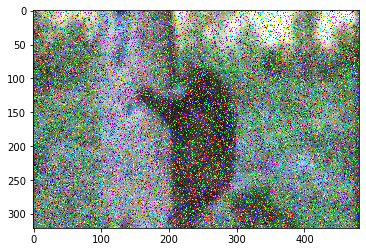

In [45]:
plt.imshow(img_test_noise[1])
plt.show()

In [25]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

In [46]:
W=101
img = img_test_noise[1]
img_re = np.zeros((img.shape[0] + 2*(W//2), img.shape[1] + 2*(W//2), 3))
for c in range(0, 3):
    img_re[:, :, c] = np.pad(img[:, :, c], W//2, pad_with, padder =0)

In [47]:
rg= []
for c in range(0, 3):
    rg.append(regressor_arr[c])

In [48]:
import sys
#https://stackoverflow.com/questions/3002085/python-to-print-out-status-bar-and-percentage
def drawProgressBar(percent, barLen = 20):
    # percent float from 0 to 1. 
    sys.stdout.write("\r")
    sys.stdout.write("[{:<{}}] {:.0f}%".format("=" * int(barLen * percent), barLen, percent * 100))
    sys.stdout.flush()


In [49]:
img_final = np.empty_like(img)
img_patch = np.empty((W, W, 3))
for c in range(0, 3):
    here = 0
    for i in range(0, img.shape[0], 20):
        for j in range(0, img.shape[1], 20):
            here += 1
            #print(here)
            drawProgressBar(here/(img.shape[0]*img.shape[1]))
            img_patch[:, :, c] = img_re[i:i+2*(W//2)+1 ,j: j+2*(W//2)+1, c]/255
            ctr_pixel = rg[c].predict(np.array(img_patch[:, :, c].flatten()).reshape(1, -1))
            img_final[i, j, c] = 1 if ctr_pixel[0]>1 else ctr_pixel[0]
img_final=np.array(255 * img_final, dtype=np.uint8)

[                    ] 0%

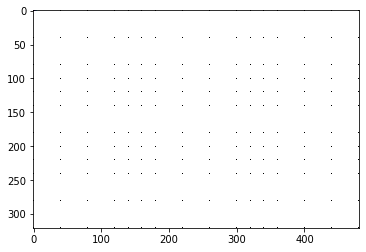

In [50]:
plt.imshow(img_final)
plt.show()